In [924]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [925]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline

In [926]:
class prediction_model:

	def __init__(self, model, filepath):

		self.model = model
		self.path = filepath

		data = self.translate_data(filepath)

		self.stored_data, self.names = self.build_training(data)

		X = self.stored_data.drop(columns=['High', 'Low', 'Volume', 'Close/Last', 'Date'] , axis=1)
		y = self.stored_data['Close/Last']

		self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=0)

######
####
##		Helper Functions to handle initiation of the model
#
###
##	Heloper function to ensure that the data is from nasdaq.com
#
	def ensure_nasdaq(self, df):
		##check headdings are correct:
		if 'Date' not in df.columns:
			raise ValueError("The data does not contain the Date column.")

		if 'Open' not in df.columns:
			raise ValueError("The data does not contain the Open column.")
		
		if 'Close/Last' not in df.columns:
			raise ValueError("The data does not contain the Close column.")
			
		if 'High' not in df.columns:
			raise ValueError("The data does not contain the High column.")
		
		if 'Low' not in df.columns:
			raise ValueError("The data does not contain the Low column.")

		if 'Volume' not in df.columns:
			raise ValueError("The data does not contain the Volume column.")
		
		print("Data is in the correct format and likely origins from nasdaq.com")

		return True
###
##	Helper function to translate the data to the correct format for analysis
#
	def translate_data(self, path):
		data = pd.read_csv(path)
		# Ensure that the data is from nasdaq.com
	
		if(not self.ensure_nasdaq(data)):
			raise ValueError("The data is not from nasdaq.com. Please provide data from nasdaq.com")
			return None


		# Translate the data and remove $ from the data and multiply close, open, high and low by a factor of 100 and convert them to integers
		data['Date'] = pd.to_datetime(data['Date'])
		data['Close/Last'] = data['Close/Last'].replace('[\$,]', '', regex=True).astype(float)
		data['Open'] = data['Open'].replace('[\$,]', '', regex=True).astype(float)
		data['High'] = data['High'].replace('[\$,]', '', regex=True).astype(float)
		data['Low'] = data['Low'].replace('[\$,]', '', regex=True).astype(float)


		# inverse the entire dataframe
		data = data.iloc[::-1]

		# reset the index
		data = data.reset_index(drop=True)

		return data
###
##	Helper function to build the training data from the raw data
#
	def build_training(self, df):
		lags = 5
		names = []


		for i in range(1, lags+1):
			df[f'lag_{i}'] = df['Close/Last'].shift(i)

			names.append(f'lag_{i}')

		df.dropna(inplace=True)

		return df, names
#
##		End of Helper Functions
####
######


######
####
##		Class method to train the model
#
	def train_model(self):

		# Create a pipeline with a standard scaler and a linear regression model
		self.pipe = self.model ##Pipeline([('scaler', MinMaxScaler(feature_range=(0, 1))), ('model', )])

		# Fit the model
		self.pipe.fit(self.X_train, self.y_train)

		return True

######
####
##		Class method to predict the test data
#
	def predict(self):

		pred = self.pipe.predict(self.X_test)

		## turn into dataframe with columnname 'Close/Last'
		self.y_pred = pd.DataFrame(pred, columns=['Close/Last'])

		## change the index of the dataframe to start at the same value as the test data
  
		self.y_pred.index = self.y_test.index



		return True
	
######
####
##		Class method to display the graphs of the predictions
#
	def graph(self):

		## create plot with 3 subplots
		fig, ax = plt.subplots(4, figsize=(25, 20))

		## plot the closes
		ax[0].plot(self.stored_data['Date'][:len(self.y_train)], self.y_train, label='Training Close Price', color='blue')
		ax[0].plot(self.stored_data['Date'][len(self.y_train):], self.y_test, label='Actual Test Close Price', color='green')
		ax[0].plot(self.stored_data['Date'][len(self.y_train):], self.y_pred, label='Predicted Test Close Price', color='red')

		## add title and legend
		ax[0].set_title('Close Price')
		ax[0].legend()


		## plot the predictions vs results
  
		ax[1].plot(self.stored_data['Date'][len(self.y_train):], self.y_test, label='Actual Test Close Price', color='blue', linestyle='-.')
		ax[1].plot(self.stored_data['Date'][len(self.y_train):], self.y_pred, label='Predicted Test Close Price', color='red', linestyle='-')

		## add title and legend
		ax[1].set_title('Close Price')
		ax[1].legend()


		plt.show()

In [927]:
prediction = prediction_model(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None), "csvs/stocks/apple.csv")

Data is in the correct format and likely origins from nasdaq.com


In [928]:
prediction.train_model()
prediction.predict()

True

In [929]:
prediction.y_pred

,Close/Last
2014,166.675470
2015,161.639637
2016,162.392383
2017,156.280412
2018,159.364572
...,...
2512,170.263739
2513,168.244076
2514,166.252879
2515,165.645683


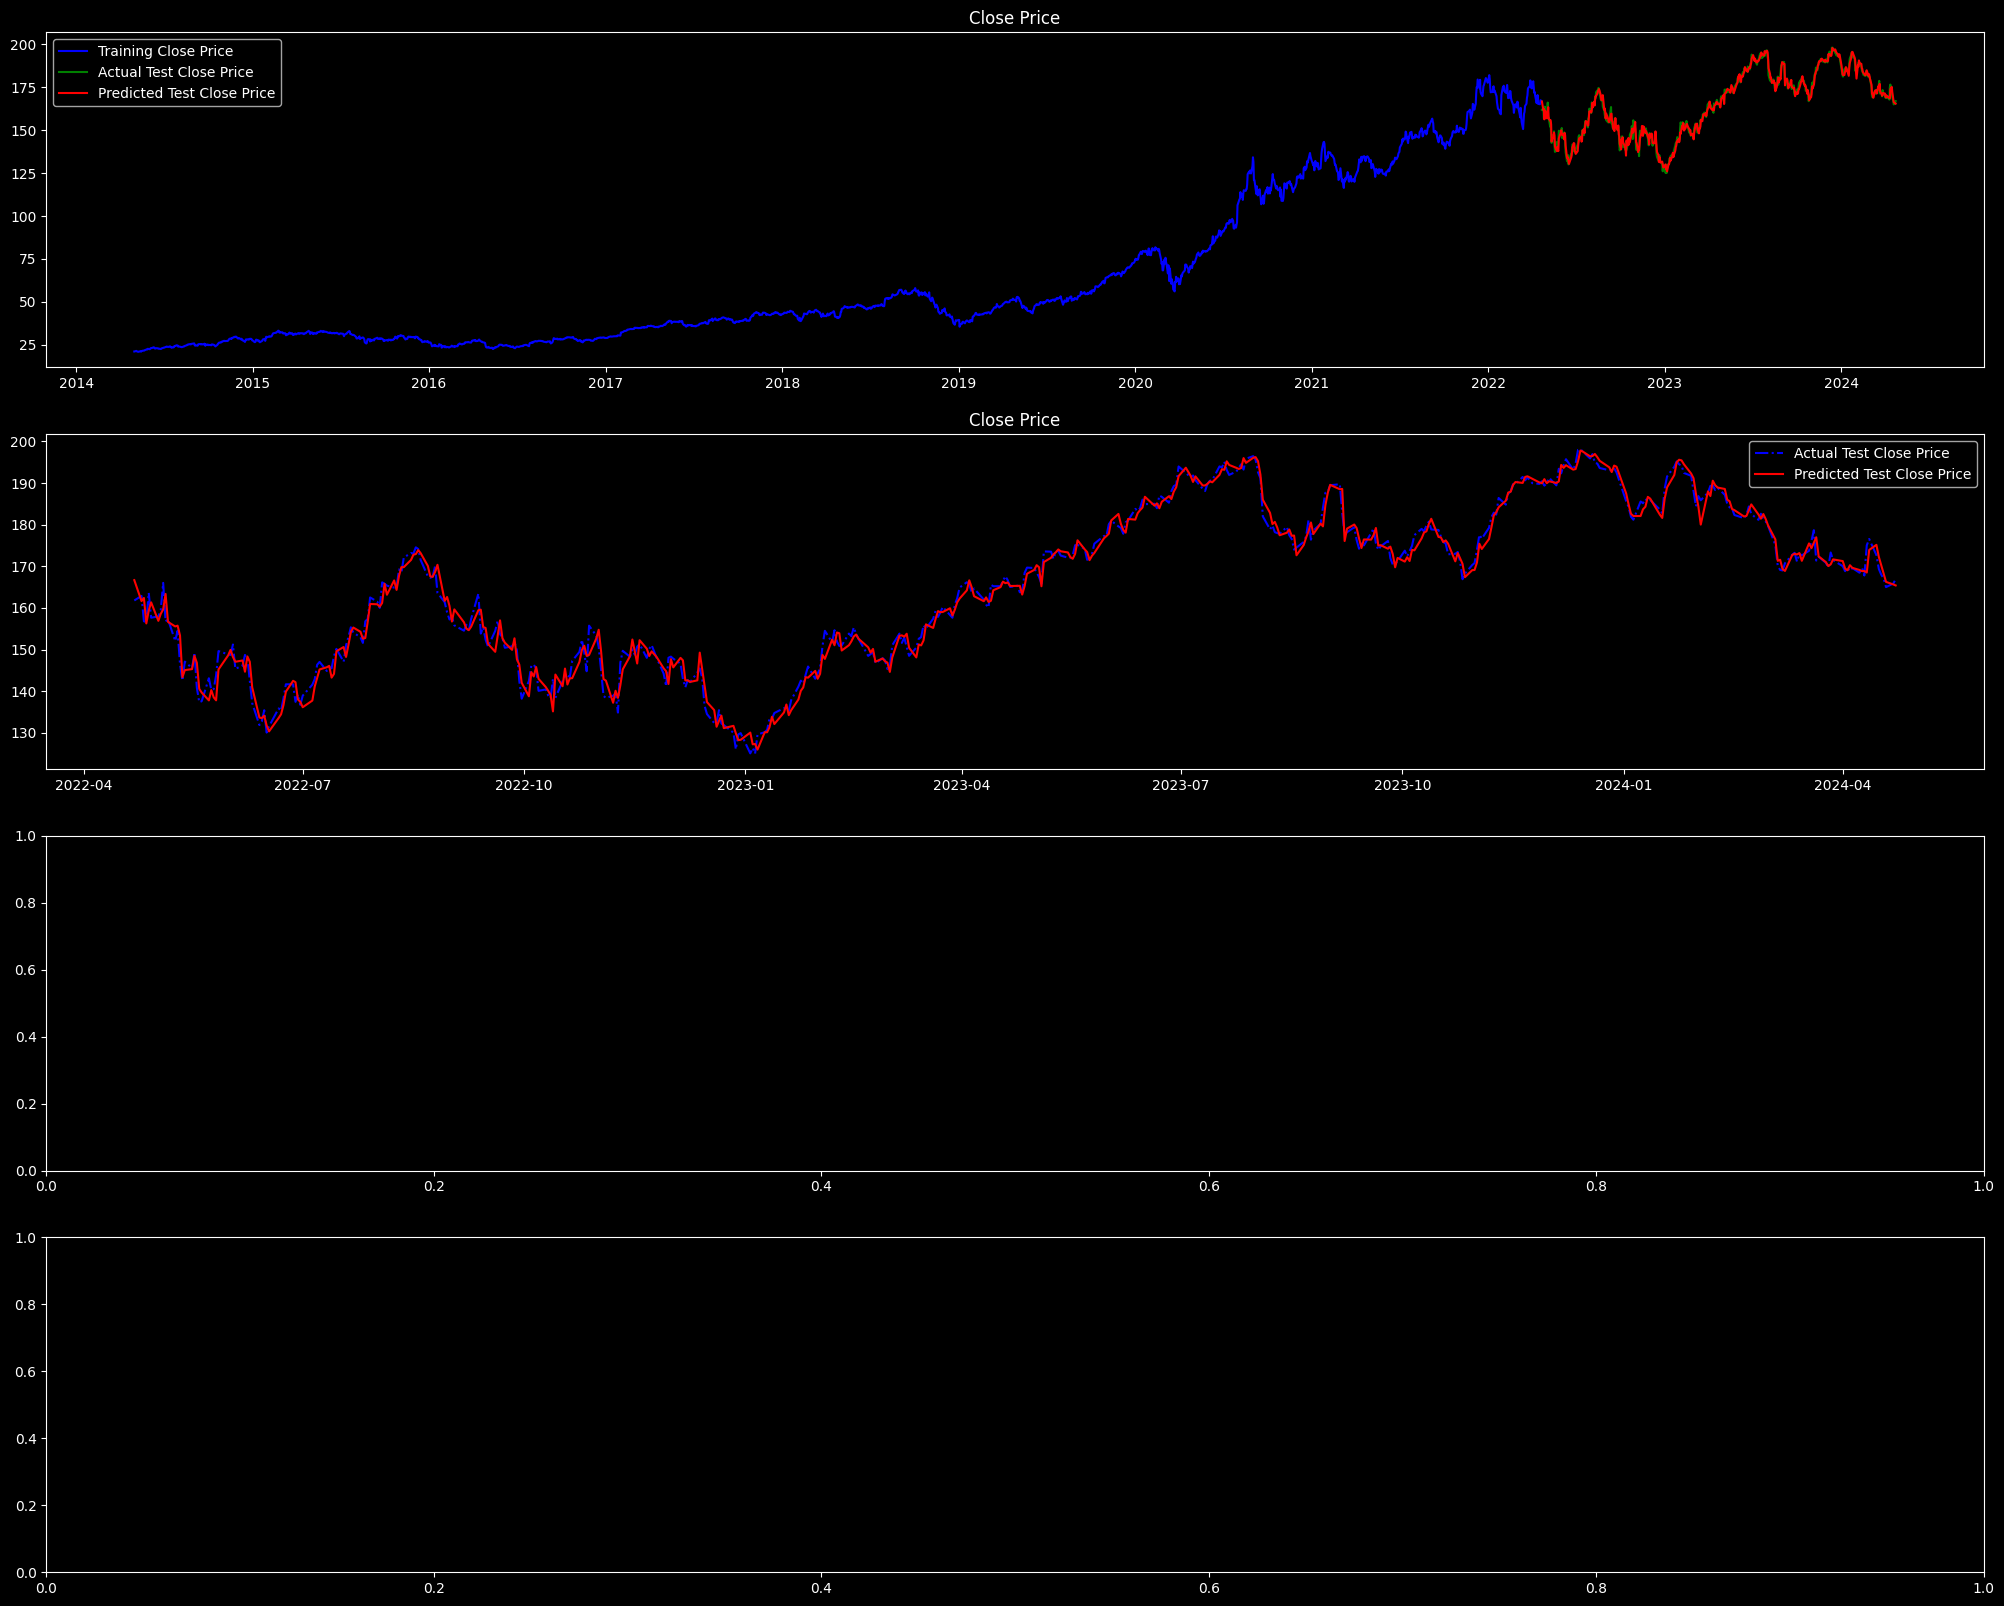

In [930]:
prediction.graph()

In [931]:
npreturns = prediction.Test['returns'].to_numpy()

AttributeError: 'prediction_model' object has no attribute 'Test'

In [ ]:
nppredictions = prediction.Test['prediction'].to_numpy()

In [ ]:
# np.exp(Test[['returns', 'strategy_returns']].sum())

In [ ]:
# np.exp(Test[['returns', 'strategy_returns']].cumsum()).plot()